# Titanic: Machine Learning from Disaster

In [1]:
# https://www.kaggle.com/c/titanic

In [1]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загружаем данные из файлов
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Предобработка данных

In [4]:
# Заполняем пропуски в данных медианными 
# значениями факторов на обучающей выборке
train_median = train.median()
train_imp = train.fillna(train_median)
test_imp = test.fillna(train_median)

In [5]:
# Бинаризуем категориальные признаки
CATEGORY_COL = ['Sex', 'Pclass', 'Embarked']
train_dummies = pd.get_dummies(train_imp, columns=CATEGORY_COL, drop_first=True)
test_dummies = pd.get_dummies(test_imp, columns=CATEGORY_COL, drop_first=True)

In [6]:
train_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,1,0,1


In [7]:
# Удаляем лишние столбцы
DROP_COL = ['PassengerId', 'Name', 'Ticket', 'Cabin']
TARGET_COL = 'Survived'
X_train = train_dummies.drop(DROP_COL + [TARGET_COL], axis=1)
y_train = train_dummies[TARGET_COL]
X_test = test_dummies.drop(DROP_COL, axis=1)

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, scorer, accuracy_score, make_scorer

## Предсказание моделей для стеккинга

In [9]:
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

def cross_val_predict_proba(estimator, X_train, y_train):
    print(estimator)
    kfold = KFold(n_splits=4, shuffle=True, random_state=None)
    return cross_val_predict(estimator, X_train, y_train, cv=kfold, method='predict_proba', n_jobs=-1)


def grid_search(model,params, X_train, y_train):
    kfold = KFold(n_splits=4, shuffle=True, random_state=None)
    local_grid = GridSearchCV(model, params,\
                              scoring=make_scorer(accuracy_score),\
                              cv=kfold, n_jobs=-1)
    local_model = local_grid.fit(X_train, y_train)
    print(model)
    print(local_grid.best_params_, local_grid.best_score_)
    return local_model


# TODO: подобрать гиперпараметры для ансамблей





In [10]:
model1 = grid_search(RandomForestClassifier(),{'n_estimators': range(30, 120, 10)}, X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
{'n_estimators': 40} 0.814814814815


In [11]:

model2 = grid_search(LogisticRegression(),{'C': [0.01,0.1,1,10,100]}, X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
{'C': 1} 0.801346801347


In [55]:
model3 = grid_search((GradientBoostingClassifier(#learning_rate=0.1, \
                                                                  min_samples_split=100,\
                                                 #                 min_samples_leaf=2,\
                                                 #                 max_features='sqrt',\
                                                 #                 subsample=0.8,\
                                                 #                 random_state=10,\
                                                                  warm_start=True)),\
                     {
                    'max_depth': range(1, 50,10),\
                    'learning_rate': [0.01,0.1],\
                    'min_samples_split': [2,10,100,200],\
                    'min_samples_leaf':[8,10,15,20]
                     }, 
                     X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=100, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=True)
{'learning_rate': 0.1, 'max_depth': 11, 'min_samples_leaf': 20, 'min_samples_split': 200} 0.841750841751


In [56]:
model1_train_pred = cross_val_predict_proba(model1, X_train, y_train)
model2_train_pred = cross_val_predict_proba(model2, X_train, y_train)
model3_train_pred = cross_val_predict_proba(model3, X_train, y_train)

GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(30, 120, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)
GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalt

In [57]:
model1_test_pred = model1.fit(X_train, y_train).predict_proba(X_test)
model2_test_pred = model2.fit(X_train, y_train).predict_proba(X_test)
model3_test_pred = model3.fit(X_train, y_train).predict_proba(X_test)

In [65]:
train_array = [model1_train_pred[:,1], model2_train_pred[:,1], model3_train_pred[:,1]]
test_array = [model1_test_pred[:,1], model2_test_pred[:,1], model3_test_pred[:,1]]

#train_array = [model1_train_pred[:,1], model3_train_pred[:,1]]
#test_array = [model1_test_pred[:,1], model3_test_pred[:,1]]




In [66]:
X_train_stack = np.stack(train_array, axis=1)
X_test_stack = np.stack(test_array, axis=1)

## Объединяем предсказания ансамблей с помощью логистической регрессии

In [67]:
# TODO: подобрать гиперпараметры LogisticRegression


kfold = KFold(n_splits=10, shuffle=True, random_state=1243)

pipeline = Pipeline(steps=[
                           ('model', LogisticRegression(C=1, penalty='l2'))
                          ])

param_grid = {'model__C': [0.001,0.01,0.1,1,10,100,1000,10000]}

grid = GridSearchCV(pipeline, param_grid, 
                    scoring=make_scorer(accuracy_score),
                    cv=kfold)

In [68]:

logreg = grid.fit(X_train_stack, y_train)
predicted = logreg.predict(X_test_stack)
logreg.cv_results_['mean_test_score']

array([ 0.80583614,  0.82154882,  0.82603816,  0.82267116,  0.82042649,
        0.82042649,  0.82042649,  0.82042649])

In [69]:
logreg.grid_scores_, logreg.best_params_, logreg.best_score_

([mean: 0.80584, std: 0.03621, params: {'model__C': 0.001},
  mean: 0.82155, std: 0.03410, params: {'model__C': 0.01},
  mean: 0.82604, std: 0.02972, params: {'model__C': 0.1},
  mean: 0.82267, std: 0.03121, params: {'model__C': 1},
  mean: 0.82043, std: 0.02879, params: {'model__C': 10},
  mean: 0.82043, std: 0.02879, params: {'model__C': 100},
  mean: 0.82043, std: 0.02879, params: {'model__C': 1000},
  mean: 0.82043, std: 0.02879, params: {'model__C': 10000}],
 {'model__C': 0.1},
 0.82603815937149272)

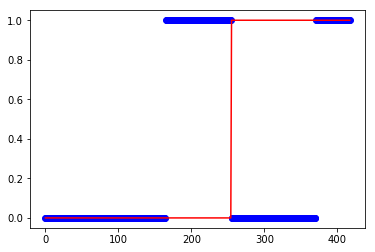

In [70]:
pairs = np.array(sorted(zip(y_train, predicted)))
plt.plot(range(0, len(pairs)), pairs[:,1], 'bo',
         range(0, len(pairs)), pairs[:,0], 'r-',)
plt.show()

## Формируем фалй для отправки

In [71]:
with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted):
        out.write('%s,%s\n' % (passenger, y))